In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import json
import torch
from ray.tune import Analysis
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn
from src.data import IFCNetPlySparse
from src.models.models import MinkowskiFCNN, MinkowskiCE2
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.nn as nn
import MinkowskiEngine as ME
from sklearn.preprocessing import label_binarize

In [3]:
data_root = Path("../data/processed/IFCGeomUniform/IFCNetCore")

with open("../IFCNetCore_Classes.json", "r") as f:
    class_names = json.load(f)

In [4]:
train_dataset = IFCNetPlySparse(data_root, class_names, partition="train")
val_dataset = IFCNetPlySparse(data_root, class_names, partition="train")
test_dataset = IFCNetPlySparse(data_root, class_names, partition="test")

np.random.seed(42)
perm = np.random.permutation(range(len(train_dataset)))
train_len = int(0.7 * len(train_dataset))
train_dataset = Subset(train_dataset, sorted(perm[:train_len]))
val_dataset = Subset(val_dataset, sorted(perm[train_len:]))

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8, collate_fn=ME.utils.SparseCollation())
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=8, collate_fn=ME.utils.SparseCollation())
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=8, collate_fn=ME.utils.SparseCollation())

In [5]:
log_dir = Path("../logs/IFCGeomUniform/DEFAULT_2021-09-14_15-43-44/")
analysis = Analysis(log_dir, default_metric="val_balanced_accuracy_score", default_mode="max")
best_trial_dir = Path(analysis.get_best_logdir())

with (best_trial_dir/"params.json").open("r") as f:
    config = json.load(f)

model = MinkowskiCE2(3, len(class_names), config["embedding_dim"], return_feats=True)
model_state, _ = torch.load(best_trial_dir/"checkpoint_249"/"checkpoint")
model.load_state_dict(model_state)

<All keys matched successfully>

In [6]:
device = torch.device("cuda")
model.eval()
model.to(device)

MinkowskiCE2(
  (mlp1): Sequential(
    (0): MinkowskiLinear(in_features=3, out_features=16, bias=False)
    (1): MinkowskiBatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiLeakyReLU()
  )
  (conv1): Sequential(
    (0): MinkowskiConvolution(in=16, out=32, kernel_size=[3, 3, 3], stride=[1, 1, 1], dilation=[1, 1, 1])
    (1): MinkowskiBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiLeakyReLU()
  )
  (down1): Sequential(
    (0): MinkowskiConvolution(in=48, out=32, kernel_size=[1, 1, 1], stride=[1, 1, 1], dilation=[1, 1, 1])
    (1): MinkowskiBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiLeakyReLU()
  )
  (conv2): Sequential(
    (0): MinkowskiConvolution(in=32, out=48, kernel_size=[3, 3, 3], stride=[1, 1, 1], dilation=[1, 1, 1])
    (1): MinkowskiBatchNorm(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiLeak

In [7]:
def calc_metrics(probabilities, labels):
    predictions = np.argmax(probabilities, axis=1)

    acc = metrics.accuracy_score(labels, predictions)
    balanced_acc = metrics.balanced_accuracy_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions, average="weighted")
    recall = metrics.recall_score(labels, predictions, average="weighted")
    f1 = metrics.f1_score(labels, predictions, average="weighted")

    return {
        f"accuracy_score": acc,
        f"balanced_accuracy_score": balanced_acc,
        f"precision_score": precision,
        f"recall_score": recall,
        f"f1_score": f1
    }

def plot_confusion_matrix(confusion_matrix, display_labels, fname=None):
    labels = list(map(lambda x: x[3:], display_labels))
    df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    plt.figure(figsize=(7, 5))
    heatmap = sn.heatmap(df, cmap="Blues", annot=True, fmt="d", cbar=False)
    plt.ylabel("Actual class")
    plt.xlabel("Predicted class")
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")

def eval(model, loader, device, class_names, fname=None):
    model.eval()
    all_probs = []
    all_labels = []
    all_embeddings = []

    with torch.no_grad():
        for coords, feats, labels in tqdm(loader):
            labels = torch.tensor(labels)
                
            coords, feats, labels = coords.to(device), feats.to(device), labels.to(device)
            tensor = ME.TensorField(feats, coords)

            outputs, embeddings = model(tensor)

            probs = F.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())
            all_embeddings.append(embeddings.cpu().detach().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    all_embeddings = np.concatenate(all_embeddings)
    result = calc_metrics(all_probs, all_labels)
    print(result)
    #predictions = np.argmax(all_probs, axis=1)
    #confusion_matrix = metrics.confusion_matrix(all_labels, predictions)
    #plot_confusion_matrix(confusion_matrix, class_names, fname=fname)
    return all_labels, all_probs, all_embeddings

In [8]:
eval(model, train_loader, device, class_names);

100%|██████████| 122/122 [00:09<00:00, 13.48it/s]

{'accuracy_score': 0.8638352638352639, 'balanced_accuracy_score': 0.8896489815672648, 'precision_score': 0.8732273540778082, 'recall_score': 0.8638352638352639, 'f1_score': 0.8659119733940998}


In [9]:
eval(model, val_loader, device, class_names);

100%|██████████| 53/53 [00:04<00:00, 12.56it/s]

{'accuracy_score': 0.8541416566626651, 'balanced_accuracy_score': 0.8874579508265283, 'precision_score': 0.8638745390365841, 'recall_score': 0.8541416566626651, 'f1_score': 0.8554920663787808}


In [8]:
test_labels, test_probs, test_embeddings = eval(model, test_loader, device, class_names)

100%|██████████| 75/75 [00:05<00:00, 13.07it/s]

{'accuracy_score': 0.8158890290037831, 'balanced_accuracy_score': 0.8301606935099011, 'precision_score': 0.8277658055034153, 'recall_score': 0.8158890290037831, 'f1_score': 0.817962167707173}


s3dis_to_ifcnet = {
    "chair": class_names.index("IfcFurniture"),
    "table": class_names.index("IfcFurniture"),
    "door": class_names.index("IfcDoor"),
    "bookcase": class_names.index("IfcFurniture"),
    "sofa": class_names.index("IfcFurniture")
}

class PointCloudTxtSparse(Dataset):

    def __init__(self, files, label_map, quantization_size=0.01, transform=None):
        self.transform = transform
        self.files = files
        self.quantization_size = quantization_size

        self.data = []
        self.labels = []
        
        for f in self.files:
            self.data.append(np.loadtxt(f, dtype=np.float32)[:, :3])
            self.labels.append(label_map[f.stem.split("_")[0]])

    def __getitem__(self, idx):
        pointcloud = self.data[idx]
        label = self.labels[idx]
        
        pointcloud = np.ascontiguousarray(pointcloud)
        pointcloud -= np.mean(pointcloud, axis=0)

        if self.transform:
            pointcloud = self.transform(pointcloud)
            
        coords = pointcloud / self.quantization_size
        feats = pointcloud
        
        # normalize
        max_len = np.max(np.sum(feats**2, axis=1))
        feats /= np.sqrt(max_len)

        return coords, feats, label

    def __len__(self):
        return len(self.data)

files = sorted(Path("/home/ce/ShapeRetrieval/S3DIS/").glob("**/**/*.txt"))
s3dis = PointCloudTxtSparse(files, s3dis_to_ifcnet)

s3dis_loader = DataLoader(s3dis, batch_size=16, num_workers=8, collate_fn=ME.utils.SparseCollation())

s3dis_labels, s3dis_probs, s3dis_embeddings = eval(model, s3dis_loader, device, class_names)

In [1]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(test_embeddings)
distances, indices = nbrs.kneighbors(s3dis_embeddings)

most_similar_files = np.array(test_dataset.files)[indices.flatten()]

export_path = Path("/home/ce/ifcnet-models/data/external/S3DISSimilarity")
export_path.mkdir(parents=True, exist_ok=True)
for i, f in enumerate(files):
    p = export_path / f.parts[-3] / f.parts[-2] / f.stem
    p.mkdir(parents=True, exist_ok=True)
    shutil.copy(most_similar_files[i], p)

In [12]:
nbrs = NearestNeighbors(n_neighbors=7, algorithm='ball_tree').fit(test_embeddings)
distances, indices = nbrs.kneighbors(test_embeddings)

In [13]:
most_similar_files = np.array(test_dataset.files)[indices[:, 1:]]
export_path = Path("/home/ce/ifcnet-models/data/external/IFCGeomUniformSimilarity")
export_path.mkdir(parents=True, exist_ok=True)
for i, f in enumerate(test_dataset.files):
    p = export_path / f.parts[-3] / f.stem
    p.mkdir(parents=True, exist_ok=True)
    for k, sim in enumerate(most_similar_files[i]):
        shutil.copy(sim, p/f"{k}_{sim.parts[-3]}.ply")

In [17]:
pca = PCA(n_components=50, random_state=31).fit_transform(test_embeddings)

In [18]:
embedded = TSNE(n_components=2, random_state=45).fit_transform(pca)

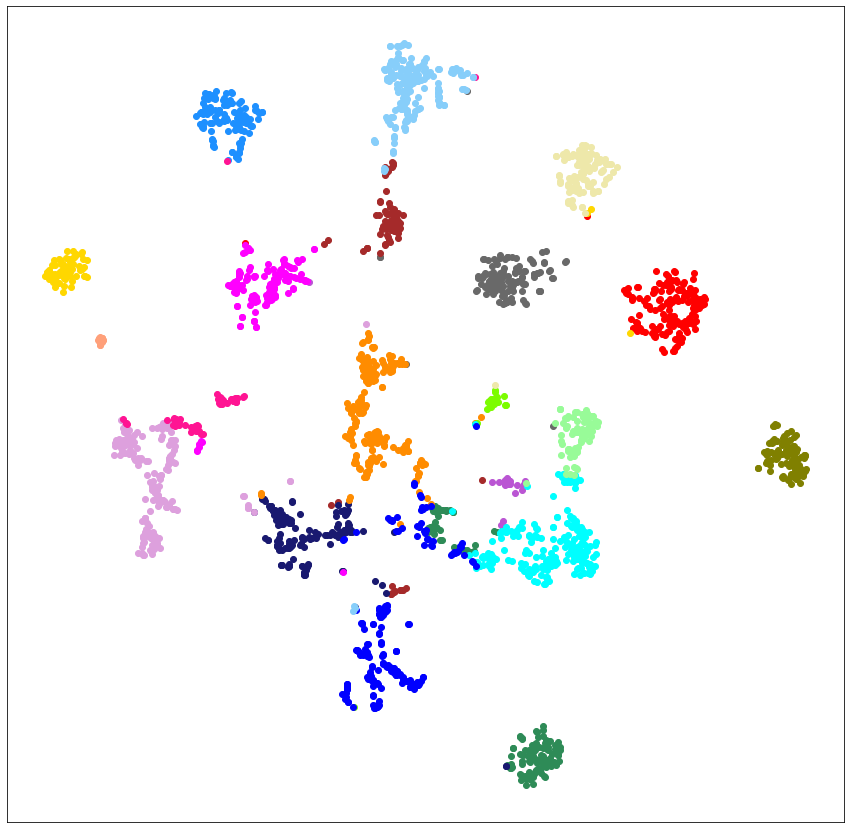

In [20]:
test_predictions = np.argmax(test_probs, axis=1)
colors = ["#696969", "#a52a2a", "#2e8b57", "#191970", "#808000", "#ff0000",
         "#ff8c00", "#ffd700", "#7cfc00", "#ba55d3", "#00ffff", "#0000ff",
         "#ff00ff", "#1e90ff", "#eee8aa", "#dda0dd", "#ff1493", "#ffa07a",
         "#98fb98", "#87cefa"]
plt.figure(figsize=(15, 15))
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
for i, cn in enumerate(class_names):
    points = embedded[test_predictions==i]
    cluster_center = points.mean(axis=0)
    plt.scatter(points[:, 0], points[:, 1], color=colors[i])
    #plt.text(cluster_center[0]-5, cluster_center[1], cn)
#plt.legend(class_names)